In [17]:
import xarray as xr
import numpy as np
import sys
import glob
import matplotlib.pyplot as plt
import pandas as pd
import dask

from smyleutils import grid_utils as grid
from smyleutils import eof_utils as eof
import importlib

<module 'smyleutils.eof_utils' from '/glade/u/home/islas/python/NCAR_CW3E_SMYLE/smyleutils/eof_utils.py'>

In [2]:
def fixtime(dat):
    diff = np.array(dat.time_bnds.isel(nbnd=1, M=0)) - np.array(dat.time_bnds.isel(nbnd=0, M=0))
    diff = diff/2.
    newtime = np.array(dat.time_bnds.isel(nbnd=0, M=0)) + diff
    dat['time'] = newtime
    return dat

In [3]:
from dask_jobqueue import PBSCluster
from dask.distributed import Client

cluster = PBSCluster(
    cores = 1,
    memory = '30GB',
    processes = 1,
    queue = 'casper',
    local_directory = '$TMPDIR',
    resource_spec = 'select=1:ncpus=1:mem=30GB',
    project='P04010022',
    walltime='01:00:00',
    interface='mgt')

# scale up
cluster.scale(12)

# change your urls to the dask dashboard so that you can see it
dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})

# Setup your client
client = Client(cluster)

/glade/u/home/islas/miniconda3/envs/islaenv24/lib/python3.7/site-packages/distributed/node.py:161: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41059 instead
  f"Port {expected} is already in use.\n"


In [6]:
cluster

PBSCluster(f4cf7d84, 'tcp://10.18.206.66:33345', workers=12, threads=12, memory=335.28 GiB)

### Set up information (start year, end year, end month, reykjavik and azores locations)

In [7]:
ystart=1970
yend=2020
init_year = np.arange(ystart,yend+1,1)
reyklon=-21.9426 ; reyklat=64.1466
azorelon=-25.6756 ; azorelat=37.7412
initmon=11
endmon = 4

### ERA5 and JRA3Q

#### Read in the data

In [22]:
basepath="/glade/campaign/cgd/cas/observations/ERA5/mon_f09/PSL/"
era5_psl=[]
for iyear in np.arange(ystart,yend+2,1): # including the year after initialization
    dat = xr.open_dataset(basepath+"PSL_"+str(iyear)+".nc")
    dat = dat/100.
    era5_psl.append(dat)
era5_psl = xr.concat(era5_psl, dim='time')
lonuse = era5_psl.lon ; latuse = era5_psl.lat
era5_psl = grid.fliplon_pos2neg(era5_psl, 'lon')
era5_psl = era5_psl.sel(lon=slice(-90,40), lat=slice(20,80)).PSL.load()

basepath="/glade/campaign/cgd/cas/islas/DATASETS/JRA3Q/mon/PSL/"
jra3q_psl=[]
for iyear in np.arange(ystart,yend+2,1):
    dat = xr.open_dataset(basepath+"PSL_JRA3Q_"+str(iyear)+".nc")
    dat = dat/100.
    jra3q_psl.append(dat)
jra3q_psl = xr.concat(jra3q_psl, dim='time')
jra3q_psl['lon'] = lonuse ; jra3q_psl['lat'] = latuse
jra3q_psl = grid.fliplon_pos2neg(jra3q_psl, 'lon')
jra3q_psl = jra3q_psl.sel(lon=slice(-90,40), lat=slice(20,80)).__xarray_dataarray_variable__.load()
    

#### Deseasonalize and grab out October to March

In [23]:
era5_psl = era5_psl.groupby('time.month') - era5_psl.groupby('time.month').mean('time')
jra3q_psl = jra3q_psl.groupby('time.month') - jra3q_psl.groupby('time.month').mean('time')

era5_psl_ondjfm = era5_psl.sel(time=era5_psl.time.dt.month.isin([10,11,12,1,2,3]))
jra3q_psl_ondjfm = jra3q_psl.sel(time=jra3q_psl.time.dt.month.isin([10,11,12,1,2,3]))

#### Calculate the EOFs

In [24]:
nao_pc_ondjfm , nao_eof_ondjfm = eof.eofcalc_pcnorm(era5_psl_ondjfm, wtype='sqrtcoslat', neofs=1, timeaxis='time', lonneg=reyklon, latneg=reyklat)
nao_pc_ondjfm_jra3q, nao_eof_ondjfm_jra3q = eof.eofcalc_pcnorm(jra3q_psl_ondjfm, wtype='sqrtcoslat', neofs=1, timeaxis='time', lonneg=reyklon, latneg=reyklat)

#### Now going to use those EOFs to compute the NAO by projecting PSL onto that EOF

### Get the NAO for ERA5

In [25]:
# Align data with the initialized hindcasts
alldat=[]
for iyear in init_year:
    begdate=str(iyear)+'-'+str(initmon).zfill(2)+'-01'
    enddate=str(iyear+1)+'-'+str(endmon).zfill(2)+'-28'
    datuse = era5_psl.sel(time=slice(begdate, enddate))
    if (iyear == ystart):
        timeuse = datuse.time
    datuse['time'] = timeuse
    alldat.append(datuse)
era5 = xr.concat(alldat, dim='init_year')
era5['init_year'] = init_year

# Remove the lead dependent climatology
era5 = era5 - era5.mean('init_year')

# Project SLP onto the ERA5 NAO
era5_eof = eof.proj_onto_eof(era5, nao_eof_ondjfm.isel(mode=0), w='sqrtcoslat').load()

# Get the station based index
reykval = era5.sel(lon=reyklon, lat=reyklat, method='nearest')
azoreval = era5.sel(lon=azorelon, lat=azorelat, method='nearest')

reykval = reykval / reykval.std('init_year')
azoreval = azoreval / azoreval.std('init_year')

era5_station = (azoreval - reykval).load()

era5_eof = era5_eof.rename('ERA5_NAO_EOFbased')
era5_station = era5_station.rename('ERA5_NAO_stationbased')

### Get the NAO for JRA3Q

In [35]:
alldat = []
for iyear in init_year:
    begdate=str(iyear)+'-'+str(initmon).zfill(2)+'-01'
    enddate=str(iyear+1)+'-'+str(endmon).zfill(2)+'-28'
    datuse = jra3q_psl.sel(time=slice(begdate, enddate))
    datuse['time'] = timeuse
    alldat.append(datuse)
jra3q = xr.concat(alldat, dim='init_year')
jra3q['init_year'] = init_year

# Remove the lead dependent climatology
jra3q = jra3q - jra3q.mean('init_year')

# Project SLP onto the JRA3Q NAO
jra3q_eof = eof.proj_onto_eof(jra3q, nao_eof_ondjfm_jra3q.isel(mode=0), w='sqrtcoslat').load()

# Get the station based index
reykval = jra3q.sel(lon=reyklon, lat=reyklat, method='nearest')
azoreval = jra3q.sel(lon=azorelon, lat=azorelat, method='nearest')

reykval = reykval / reykval.std('init_year')
azoreval = azoreval / azoreval.std('init_year')

jra3q_station = (azoreval - reykval).load()

jra3q_eof = jra3q_eof.rename('JRA3Q_NAO_EOFbased')
jra3q_station = jra3q_station.rename('JRA3Q_NAO_stationbased')

### L83

In [27]:
topdir="/glade/campaign/cesm/development/espwg/SMYLE-CW3E-L83/timeseries/"
nmems=20

alldat=[]
for iyear in init_year:
    filelist = [ glob.glob(topdir+"b.e21.BSMYLE-CW3E-L83.f09_g17."+str(iyear)+'-'+str(initmon)+'.'+str(imem).zfill(3)+"/atm/proc/tseries/month_1/*.cam.h0.PSL.*.nc")[0] 
                for imem in np.arange(1,nmems+1,1) ]
    dat = xr.open_mfdataset(filelist, concat_dim='M', combine='nested')
    dat['lon'] = lonuse ; dat['lat'] = latuse
    if (iyear == ystart):
        dat = fixtime(dat)
        timeuse = dat.time
    dat['time'] = timeuse
    dat = grid.fliplon_pos2neg(dat, 'lon')
    dat = dat.sel(lon=slice(-90,40), lat=slice(20,80))
    dat = dat.PSL/100.
    alldat.append(dat)
alldat = xr.concat(alldat, dim='init_year')
alldat['init_year'] = init_year

# remove the lead dependent climatology
alldat = alldat - alldat.mean('init_year')

high_eof = eof.proj_onto_eof(alldat, nao_eof_ondjfm.isel(mode=0), w='sqrtcoslat').load()
reykval = alldat.sel(lon=reyklon, lat=reyklat, method='nearest')
azoreval = alldat.sel(lon=azorelon, lat=azorelat, method='nearest')
reykval = reykval / reykval.std('init_year')
azoreval = azoreval / azoreval.std('init_year')

high_station = (azoreval - reykval).load()

high_eof = high_eof.rename('L83_NAO_EOFbased')
high_station = high_station.rename('L83_NAO_stationbased')

### L32

In [28]:
topdir="/glade/campaign/cesm/development/espwg/SMYLE-CW3E/timeseries/"
nmems=20

alldat=[]
for iyear in init_year:
    print(iyear)
    filelist = [ glob.glob(topdir+"b.e21.BSMYLE-CW3E.f09_g17."+str(iyear)+'-'+str(initmon)+'.'+str(imem).zfill(3)+"/atm/proc/tseries/month_1/*.cam.h0.PSL.*.nc")[0] 
                for imem in np.arange(1,nmems+1,1) ]
    dat = xr.open_mfdataset(filelist, concat_dim='M', combine='nested')
    dat = fixtime(dat)
    dat = dat.sel(time=slice(str(iyear)+'-'+str(initmon).zfill(2)+'-01',str(iyear+1)+'-'+str(endmon).zfill(2)+'-28'))
    dat['lon'] = lonuse ; dat['lat'] = latuse
    if (iyear == ystart):
        timeuse = dat.time
    dat['time'] = timeuse
    dat = grid.fliplon_pos2neg(dat, 'lon')
    dat = dat.sel(lon=slice(-90,40), lat=slice(20,80))
    dat = dat.PSL/100.
    alldat.append(dat)
alldat = xr.concat(alldat, dim='init_year')
alldat['init_year'] = init_year

# remove the lead dependent climatology
alldat = alldat - alldat.mean('init_year')

low_eof = eof.proj_onto_eof(alldat, nao_eof_ondjfm.isel(mode=0), w='sqrtcoslat').load()
reykval = alldat.sel(lon=reyklon, lat=reyklat, method='nearest')
azoreval = alldat.sel(lon=azorelon, lat=azorelat, method='nearest')

reykval = reykval / reykval.std('init_year')
azoreval = azoreval / azoreval.std('init_year')

low_station = (azoreval - reykval).load()

low_eof = low_eof.rename('L32_NAO_EOFbased')
low_station = low_station.rename('L32_NAO_stationbased')

1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020


### Align the time axes

In [36]:
high_eof['time'] = era5_eof.time
high_station['time'] = era5_eof.time
low_eof['time'] = era5_eof.time
low_station['time'] = era5_eof.time
jra3q_eof['time'] = era5_eof.time
jra3q_station['time'] = era5_eof.time

### Combine all the outputs

In [37]:
alldat = xr.merge([era5_eof, era5_station, jra3q_eof, jra3q_station, high_eof, high_station, low_eof, low_station])

In [38]:
alldat.to_netcdf("/glade/campaign/cgd/cas/islas/python_savs/NCAR_CW3E_SMYLE/DATA_SORT/NAO/NAO_eof_and_station_init"+str(initmon).zfill(2)+'.nc')

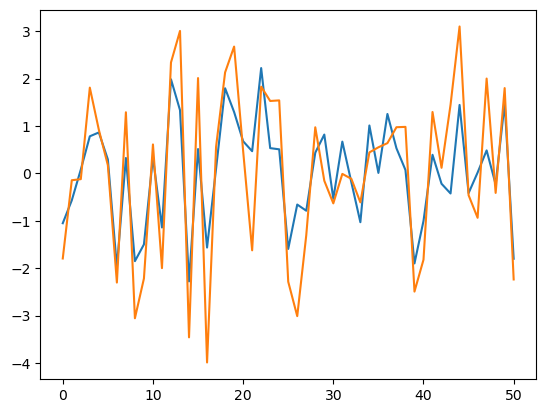

In [41]:
plt.plot(era5_eof.isel(time=2))
plt.plot(era5_station.isel(time=2))

In [42]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError
